# Before you use this notebook:

In order to fully understand this notebook, it is mandatory to read the article linked to this notebook. A preprint can be found in the GitHub repository. An article on Arxiv will be published on october 2023.

# Libraries

Let's start by installing two libraries which are called E2CNN and VTK. E2CNN allows us to use equivariant convolutional networks and VTK to read .vtk files which contain the microstructure images. Other libraries such as Pytorch, Numpy, Matplotlib and more will be used. These libraries also need to be installed on your machine if that's not already the case.

In [ ]:
pip install e2cnn, vtk

Let's import all the libraries.

In [1]:
import os
import vtk
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchmetrics.regression import WeightedMeanAbsolutePercentageError, MeanAbsoluteError
import random
import statistics
from e2cnn import gspaces
from e2cnn import nn as enn
import time
import sys
from PIL import Image

# Import Database

I am currently not allowed to share the database. If interested, please contact Julien Boisse at julien.boisse@univ-lorraine.fr

Caution: 3 folders don't contain the file "craft.res", which contains both shear storage and shear loss moduli. They will therefore be ignored:
- 20230621120759
- 20230621123750
- 20230621123827

In [ ]:
path = ".../database/results" #Insert the absolute path where the database is located.
microstructures_path = os.listdir(path)

ID = 0 #Microstructure ID

#Input images
microstructure_images = []

#Sortie
output = dict()
output['ID'] = [] #Microstructure ID
output['X'] = [] #Horizontal axis of the moduli
output['G'] = [] #Values of shear storage modulus
output['G_prime'] = [] #Values of shear loss modulus


for microstructure in microstructures_path:
    folder_dir = os.listdir(path+'/'+microstructure)
    if "craft.res" not in folder_dir:
        print(f"Caution: the folder {microstructure} doesn't contain the file craft.res")
    else:
        #Image import thanks to VTK
        reader = vtk.vtkStructuredPointsReader()
        reader.SetFileName(path+'/'+microstructure+'/voxel_mesh0256x0256x0001_craft_ASCII_POINT_DATA.vtk')
        reader.Update()
        data = reader.GetOutput()
        point_data = data.GetPointData()
        image_data = point_data.GetArray(0)
        image_array = np.array(image_data,dtype=np.float32) #Pytorch wants it to be in float32 format.
        image_matrix = np.reshape(image_array, (256, 256))
        microstructure_images.append(image_matrix)

        #Outputs import
        output_data = [i.strip().split() for i in open(path+'/'+microstructure+'/craft.res').readlines()]
        output_data = output_data[4:len(output_data)-1]
        output['ID'].append(ID)
        output['X'].append([float(element[0]) for element in output_data]) 
        output['G'].append([float(element[23])/2 for element in output_data]) #Storage modulus needs to be divided by 2.
        output['G_prime'].append([float(element[24])/2 for element in output_data]) #Loss modulus needs to be divided by 2.
        ID += 1

# Preprocessing, train, test and validation sets

## Image preprocessing

A small preprocessing step is needed for the images.

- A dimension to the 256x256 matrices (which represent our microstructures) needs to be added, so that Pytorch recognizes that it is a 2D grayscale image (1 color channel).

- Additionally, we have to substract 0.5 to each coefficient of the matrix, so that each of its values is either equal to 0.5 or -0.5. This has shown to improve the convolutional neural network's performance.

Moreover we are going to shape the output as a tuple of two lists of 30 numbers each (30 points of the storage modulus and 30 points of the loss modulus as a function of frequency). Since the horizontal axis points are identical for every observation, the horizontal axis points don't have to be used for the deep learning model.

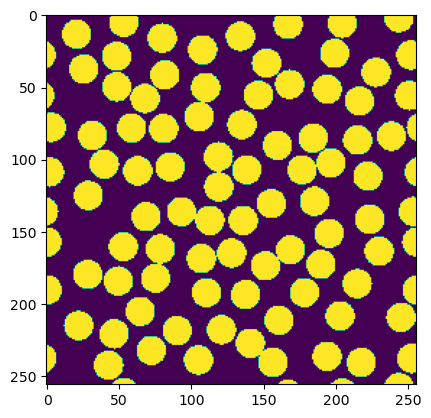

In [86]:
microstructure_images = [image[np.newaxis,:, :] - 0.5 for image in microstructure_images]
plt.imshow(microstructure_images[10000][0])

## Optional save of the database

Importing the data from the .vtk and .res files takes time. If you want to import the data faster the next time you use this notebook, it might be useful to save the database as a pickle file.

In [171]:
save_path = "" #Absolute path where you want to save the database
with open(save_path+"X.pkl", 'wb') as file:
    pickle.dump(output['X'][0], file)
with open(save_path+"G.pkl", 'wb') as file:
    pickle.dump(output['G'], file)
with open(save_path+"G_prime.pkl", 'wb') as file:
    pickle.dump(output['G_prime'], file)
with open(save_path+"microstructure_images.pkl", 'wb') as file:
    pickle.dump(microstructure_images, file)

## Load the database (once it has been saved)

In [2]:
save_path = "" #Absolute path where the database has been saved
with open(save_path+"microstructure_images.pkl", 'rb') as file:
    microstructure_images = pickle.load(file)
with open(save_path+"G.pkl", 'rb') as file:
    G = pickle.load(file)
with open(save_path+"G_prime.pkl", 'rb') as file:
    G_prime = pickle.load(file)
with open(save_path+"X.pkl", 'rb') as file:
    X = pickle.load(file)

## Data augmentation

## Translations

As mentioned in the article, all RVE's from the database have periodic boundary conditions. In order for the model to understand these conditions, one solution would be to augment the data with random translations of the image. Here, we decided to add 4 translations: 2 horizontal and 2 vertical ones.

In [3]:
length_data = len(microstructure_images)

for i in range(length_data):
    image = microstructure_images[i]
    #Horizontal
    for j in range(2):
        slice_number = random.randint(1, 255)
        left_part = image[:,:, :slice_number]
        right_part = image[:,:, slice_number:]
        microstructure_images.append(np.concatenate((right_part, left_part), axis=2))
    #Vertical
    for j in range(2):
        slice_number = random.randint(1, 255)
        left_part = image[:, :slice_number, :]
        right_part = image[:, slice_number:, :]
        microstructure_images.append(np.concatenate((right_part, left_part), axis=1))
    
    G += 4*[G[i]]
    G_prime += 4*[G_prime[i]]

## Rotations & Symetries (can be used for the test set)

Since we use equivariant CNN's (which are invariant to 90 degrees rotations and horizontal/vertical symetries, we don't have to augment the data with such transformations for training the mode. However, the test set can be augmented if you want to compare this model with other ones which don't use an equivariant CNN approach.

In [5]:
length_data = len(microstructure_images)
for i in range(length_data):
    image = microstructure_images[i]
    image_flipped = image[:,:, ::-1]
    microstructure_images.append(image_flipped)
    for step in range(1,4):
        microstructure_images.append(np.rot90(image,k=step,axes=(1,2)))
        microstructure_images.append(np.rot90(image_flipped,k=step,axes=(1,2)))
    G += 7*[G[i]]
    G_prime += 7*[G_prime[i]]

Let's check that the input and the outputs have the same size:

In [4]:
print(len(microstructure_images),len(G),len(G_prime))

69966 69966 69966


We will now be able to create our train, test and validation sets thanks to Pytorch. Here we chose a batch size of 40. 70% of the data will be used to train the model, 15% for validation and 15% to test the model.

In [5]:
#Use the GPU if CUDA-compatible
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 40

class CustomDataset(Dataset):
    def __init__(self, data, labels1, labels2):
        self.data = data
        self.labels1 = labels1
        self.labels2 = labels2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        sample = torch.from_numpy(np.ascontiguousarray(img)).float()
        label1 = self.labels1[index]
        label2 = self.labels2[index]
        return sample, (torch.FloatTensor(label1),torch.FloatTensor(label2))

dataset = CustomDataset(microstructure_images, G,G_prime)

# Validation and test ratios:
val_ratio = 0.15
test_ratio = 0.15

#Computation of the size of train, validation and test sets:
val_size = int(len(dataset) * val_ratio)
test_size = int(len(dataset) * test_ratio)
train_size = len(dataset) - val_size - test_size

# Split the dataset in train, validation and test sets:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Pytorch dataloaders:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# The model

## Architecture of the model

In [6]:
torch.cuda.empty_cache() #Empty Pytorch's GPU Memory Cache

learning_rate = 0.001

#Equivariant CNN-RNN model:
#We are now going to use the E2CNN library.

class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.g_space = gspaces.FlipRot2dOnR2(N=4) #Definition of the invariant space 
                                                  #(90° rotations and horizontal/vertical symetries)
       
        in_type = enn.FieldType(self.g_space, [self.g_space.trivial_repr])
        self.input_type = in_type

        #For each equivariant convolutional layer, 8 parallel convolutional sublayers are actually created
        #(one for each unique symetry/rotation combination)
        
        self.conv1 = self._get_equivariant_conv(1,16)
        self.conv2 = self._get_equivariant_conv(16, 32)
        self.conv3 = self._get_equivariant_conv(32, 48)
        self.conv4 = self._get_equivariant_conv(48, 64)
        self.conv5_1 = self._get_equivariant_conv(64, 82)
        self.conv5_2 = self._get_equivariant_conv(64, 82)
        self.conv6_1 = self._get_equivariant_conv(82, 112)
        
        #At the end of the equivariant convolutional layers, a 'Group Pooling' is applied to group all the 
        #features obtained by each combination of rotation/symmetry in order to extract intrinsic microstructure 
        #features, regardless of their rotation/symmetry.
        
        self.gpool_1 = enn.GroupPooling(enn.FieldType(self.g_space, [self.g_space.regular_repr]*112))
        self.gpool_2 = enn.GroupPooling(enn.FieldType(self.g_space, [self.g_space.regular_repr]*82))
        
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(360, 30)
        self.fc_2 = nn.Linear(360, 30)
        self.GRU_1 = nn.GRU(4*4*112, 360, num_layers = 3, dropout = 0.2) #For the storage modulus
        self.lstm_2 = nn.LSTM(8*8*82, 360, num_layers = 2, dropout = 0.3)  #For the loss modulus
        
        
    def _get_equivariant_conv(self, in_channels, out_channels, kernel_size = 3):
        if in_channels == 1:
            in_type = enn.FieldType(self.g_space, [self.g_space.trivial_repr]*in_channels)
        else:
            in_type = enn.FieldType(self.g_space, [self.g_space.regular_repr]*in_channels)
            out_type = enn.FieldType(self.g_space, [self.g_space.regular_repr]*out_channels)
            block = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size= kernel_size, padding=1, stride = 1, dilation = 1, padding_mode = "circular"),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True),
            enn.PointwiseMaxPoolAntialiased(out_type, kernel_size = 2))
        return block


    def forward(self, x):
        #CNN part which is common to both moduli
        
        x = enn.GeometricTensor(x, self.input_type)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        #Split into two parallel CNN+RNN sub-blocks :
        
        #1st block (storage modulus):
        x1 = self.conv5_1(x)
        x1 = self.conv6_1(x1)
        x1 = self.gpool_1(x1)
        x1 = x1.tensor
        x1 = self.flatten(x1)
        x1, h_1 = self.GRU_1(x1)
        x1 = (self.fc_1(x1))
        
        #2nd block (loss modulus):
        x2 = self.conv5_2(x)
        x2 = self.gpool_2(x2)
        x2 = x2.tensor
        x2 = self.flatten(x2)
        x2, h_2 = self.lstm_2(x2)
        x2 = (self.fc_2(x2))
        return x1,x2

# Creation of the CNN-RNN model:
model = CNNLSTM()
model.to(device) #GPU usage

# Define the loss function and optimizer
criterion = WeightedMeanAbsolutePercentageError().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001)

/srv/conda/envs/notebook/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660070785140/work/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


## Training and validation loop

In [7]:
# Display of a loading bar for each epoch
def progress_bar(current, total, start_time):
    elapsed_time = time.time() - start_time
    progress = current / total
    progress_length = int(30 * progress)

    bar = '=' * progress_length + '>' + '.' * (30 - progress_length)

    sys.stdout.write('\r')
    sys.stdout.write(f'Progression: [{bar}] {current}/{total} Elapsed time: {elapsed_time:.2f}s')
    sys.stdout.flush()

In [ ]:
num_epochs = 100

#Train loss as a function of epoch
train_history = []
G_history = []
G_prime_history = []

#Validation loss as a function of epoch
val_history = []
G_val_history = []
G_prime_val_history = []

start_time = time.time()

#Train loop
for epoch in range(num_epochs):
    model.train()  #Training mode
    train_loss = 0.0
    G_loss = 0.0
    G_prime_loss = 0.0
    count = 0
    
    for batch_data, (batch_target1,batch_target2) in train_dataloader:
        
        progress_bar(count, len(train_dataloader), start_time) #Display of the loading bar for each epoch
        
        #Gradients initialized to zero:
        optimizer.zero_grad()
        
        #Forward pass:
        out1, out2 = model(batch_data.to(device))

        #Loss computation:
        loss1 = criterion(out1, batch_target1.to(device))
        loss2 = criterion(out2, batch_target2.to(device))
        loss = loss1 + loss2
        
        #Backpropagation and weights update:
        loss.backward()
        optimizer.step()
        
        #Mesure de performance de la batch:
        G_loss += loss1.item() * batch_data.size(0)
        G_prime_loss += loss2.item() * batch_data.size(0)
        train_loss += loss.item() * batch_data.size(0)
        
        count += 1
        
    
    G_loss /= len(train_dataset)
    G_prime_loss /= len(train_dataset)
    train_loss /= len(train_dataset)
    train_history.append(train_loss)
    G_history.append(G_loss)
    G_prime_history.append(G_prime_loss)

    
    # Validation:
    model.eval()  #Evaluation mode
    val_loss = 0.0
    G_loss_val = 0.0
    G_prime_loss_val = 0.0
    
    with torch.no_grad():
        for batch_data, (batch_target1,batch_target2) in val_dataloader:
            
            #Forward pass
            batch_data = batch_data.to(device)
            out1, out2 = model(batch_data)
            target1 = batch_target1.to(device)
            target2 = batch_target2.to(device)
            
            #Loss computation
            loss1 = criterion(out1, target1)
            loss2 = criterion(out2, target2)
            loss = loss1 + loss2 
            
            G_loss_val += loss1.item() * batch_data.size(0)
            G_prime_loss_val += loss2.item() * batch_data.size(0)
            val_loss += loss.item() * batch_data.size(0)

        G_loss_val /= len(val_dataset)
        G_prime_loss_val /= len(val_dataset)
        val_loss /= len(val_dataset)
            
        val_history.append(val_loss)
        G_val_history.append(G_loss_val)
        G_prime_val_history.append(G_prime_loss_val)
        
        #The model is saved at the epoch where the validation error is the lowest.
        if val_loss <= min(val_history):
            torch.save(model.state_dict(), "best_model.pt")
            
    start_time = time.time()
    
    #Results display
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")
    print(f"Train Loss: Storage modulus: {G_loss:.5f}, Loss modulus: {G_prime_loss:.5f}")
    print(f"Validation Loss: Storage modulus: {G_loss_val:.5f}, Loss modulus: {G_prime_loss_val:.5f}")

I disabled the output of the last cell since it was too long.

## (Optional) Train and validation history curves

Here is a code to plot the train and validation history curves.

In [ ]:
x = np.linspace(1,len(train_history),len(train_history))
y_list = [[train_history, val_history],[G_history, G_val_history], [G_prime_history,G_prime_val_history]]

fig, axs = plt.subplots(3,constrained_layout = True)
fig.suptitle('Erreurs en fonction des epochs')
axs[0].set_title('Erreurs globales')
axs[1].set_title('Erreurs module d\'élasticité')
axs[2].set_title('Erreurs module de perte')
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='MSE')
    ax.set_yscale('log')
for i in range(0,3):
    axs[i].plot(x,y_list[i][0], label = 'Entraînement')
    axs[i].plot(x,y_list[i][1], label = 'Validation')
    axs[i].legend()

# Testing the model

Once the model has been trained, we can see how the model performs on the test set.

In [6]:
torch.cuda.empty_cache() #Clear GPU cache

model = CNNLSTM()
model.load_state_dict(torch.load("best_model.pt")) #Use the model which validation error was the lowest.
model.to(device) #Usage of the GPU.
model.eval()

test_loss = 0.0
G_test = 0.0
G_prime_test = 0.0

criterion2 = nn.MSELoss()

MAPE = WeightedMeanAbsolutePercentageError().to(device)
G_MAPE = 0.0
G_prime_MAPE = 0.0
storage_MAPE = []
loss_MAPE = []

MAE = MeanAbsoluteError().to(device)
G_MAE = 0.0
G_prime_MAE = 0.0
storage_MAE = []
loss_MAE = []

with torch.no_grad():
    for batch_data, (batch_target1,batch_target2) in test_dataloader:
        
        batch_data = batch_data.to(device)
        out1, out2 = model(batch_data)
        target1 = batch_target1.to(device)
        target2 = batch_target2.to(device)

        #Loss computation
        loss1 = criterion2(out1, target1)
        loss2 = criterion2(out2, target2)
        loss = loss1 + loss2
        
        G_test += loss1.item() * batch_data.size(0)
        G_prime_test += loss2.item() * batch_data.size(0)
        test_loss += loss.item() * batch_data.size(0)
        
        MAPE_error_1 = MAPE(out1, target1).item()
        MAPE_error_2 = MAPE(out2, target2).item()
        MAE_error_1 = MAE(out1, target1).item()
        MAE_error_2 = MAE(out2,target2).item()
        
        G_MAPE += MAPE_error_1 * batch_data.size(0)
        G_prime_MAPE += MAPE_error_2 * batch_data.size(0)
        G_MAE += MAE_error_1 * batch_data.size(0)
        G_prime_MAE += MAE_error_2 * batch_data.size(0)
        
        # Standard deviation computation on the MAE and wMAPE:
        for i in range(len(out1)):
            storage_MAE.append(MAE_error_1)
            loss_MAE.append(MAE_error_2)
            storage_MAPE.append(MAPE_error_1)
            loss_MAPE.append(MAPE_error_2)
    
    test_loss /= len(test_dataset)
    G_test /= len(test_dataset)
    G_prime_test /= len(test_dataset)
    G_MAPE /= len(test_dataset)
    G_prime_MAPE /= len(test_dataset)
    G_MAE /= len(test_dataset)
    G_prime_MAE /= len(test_dataset)
    
    stdev_storage_MAE = statistics.stdev(storage_MAE)
    stdev_loss_MAE = statistics.stdev(loss_MAE)
    stdev_storage_MAPE = statistics.stdev(storage_MAPE)
    stdev_loss_MAPE = statistics.stdev(loss_MAPE)

errors_dict = {'MSE': [G_test, G_prime_test],
        'MAPE': [f"{100*G_MAPE:.2f}% +/- {100*stdev_storage_MAPE:.2f}%", f"{100*G_prime_MAPE:.2f}% +/- {100*stdev_loss_MAPE:.2f}%"],
        'MAE': [f"{G_MAE:.4f} +/- {stdev_storage_MAE:.4f}", f"{G_prime_MAE:.4f} +/- {stdev_loss_MAE:.4f}"] }
errors = pd.DataFrame(errors_dict)

name_rows = ['Module de stockage', 'Module de perte']
errors = errors.rename(index=dict(enumerate(name_rows)))

print(f"Erreur de test globale: {test_loss:.5f} \n")
print(errors.transpose().head())

## Prediction example:

## Storage modulus example

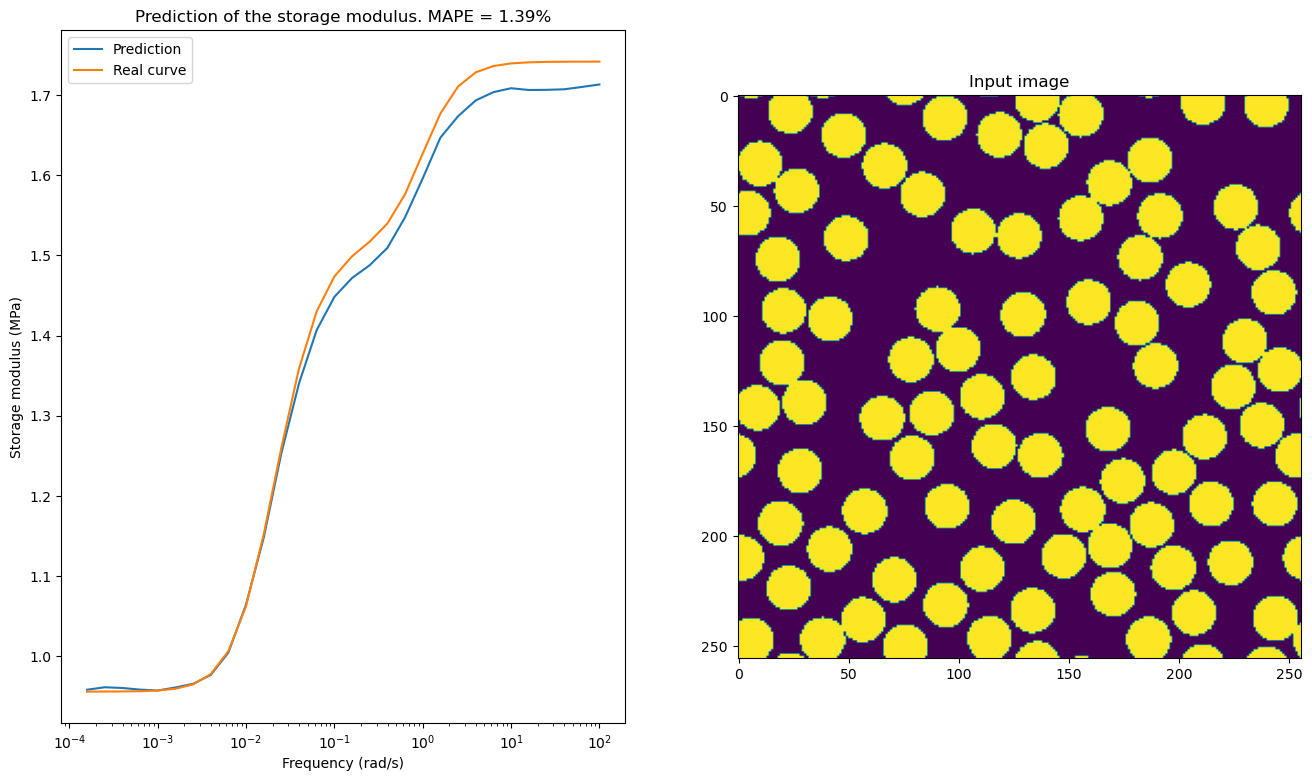

In [26]:
fraction = 0.55 #Fraction between 0 and 1. The closer to 1 the fraction, the higher the volume fraction of the microstructure
MAPE = WeightedMeanAbsolutePercentageError().to(device)
number = int(fraction*length_data)
prev_example = CustomDataset([microstructure_images[number]], [G[number]],[G_prime[number]])
prev_example = DataLoader(prev_example, batch_size=1, shuffle=False)
model.eval()
for batch_data, (batch_target1,batch_target2) in prev_example: 
        batch_data = batch_data.to(device)
        out1, out2 = model(batch_data)
        target1 = batch_target1.to(device)
        target2 = batch_target2.to(device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.plot(X,out1[0].tolist(), label = 'Prediction')
ax1.plot(X,target1[0].tolist(), label = 'Real curve')
ax1.set_title(f"Prediction of the storage modulus. MAPE = {100*MAPE(out1[0], target1[0]):.2f}%")
ax1.legend()
ax1.set(xlabel = 'Frequency (rad/s)')
ax1.set(ylabel = 'Storage modulus (MPa)')
ax1.set(xscale = 'log')
ax2.imshow(batch_data[0][0].cpu().detach().numpy())
ax2.set_title('Input image')
plt.show()

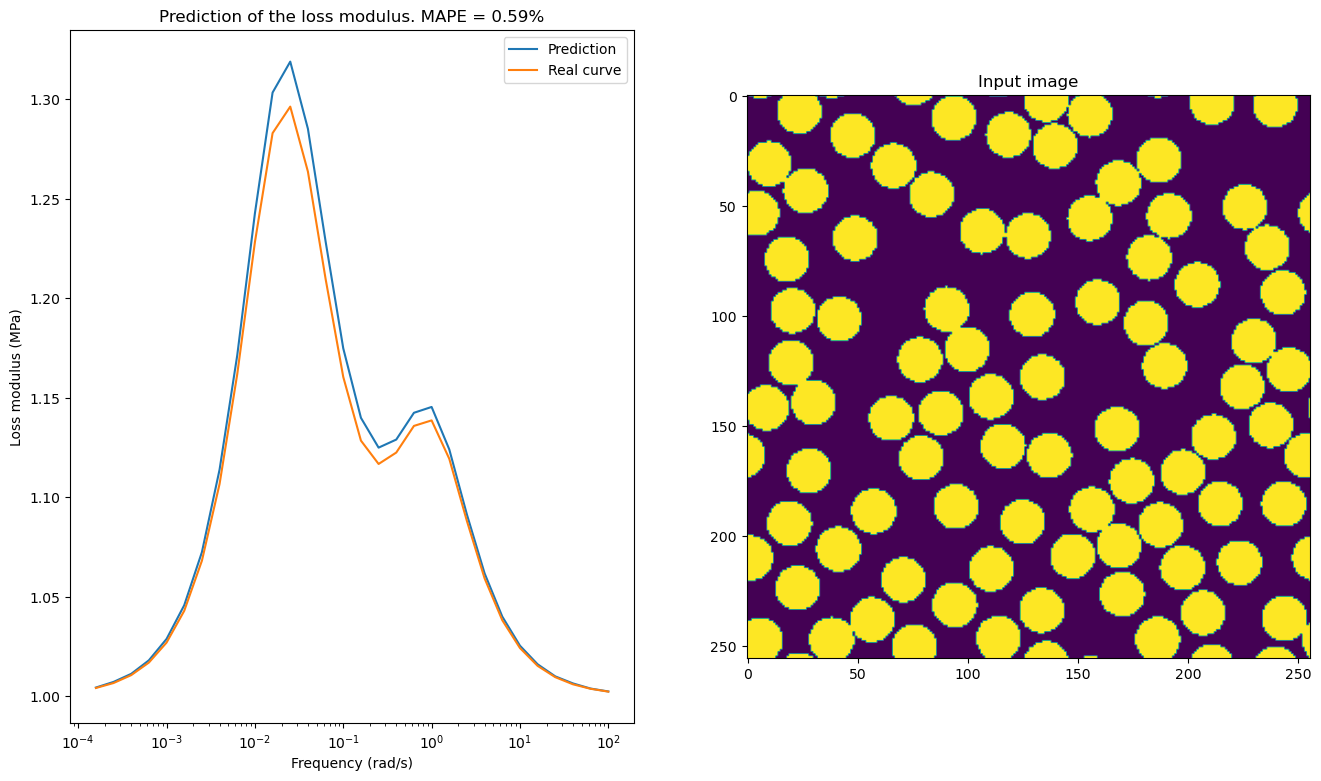

In [28]:
fraction = 0.56 #Fraction between 0 and 1. The closer to 1 the fraction, the higher the volume fraction of the microstructure

number = int(fraction*14997)
prev_example = CustomDataset([microstructure_images[number]], [G[number]],[G_prime[number]])
prev_example = DataLoader(prev_example, batch_size=1, shuffle=False)
model.eval()
for batch_data, (batch_target1,batch_target2) in prev_example: 
        batch_data = batch_data.to(device)
        out1, out2 = model(batch_data)
        target1 = torch.exp(batch_target1.to(device))
        target2 = torch.exp(batch_target2.to(device))
        out1, out2 = torch.exp(out1), torch.exp(out2)
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.plot(X,out2[0].tolist(), label = 'Prediction')
ax1.plot(X,target2[0].tolist(), label = 'Real curve')
ax1.set_title(f"Prediction of the loss modulus. MAPE = {100*MAPE(out2[0], target2[0]):.2f}%")
ax1.legend()
ax1.set(xlabel = 'Frequency (rad/s)')
ax1.set(ylabel = 'Loss modulus (MPa)')
ax1.set(xscale = 'log')
ax2.imshow(batch_data[0][0].cpu().detach().numpy())
ax2.set_title('Input image')
plt.show()

## MAPE as a function of volume fraction

With the purpose of assessing the robustness of our model, we conducted an analysis of its
performance on each RVE as a function of the volume fraction.

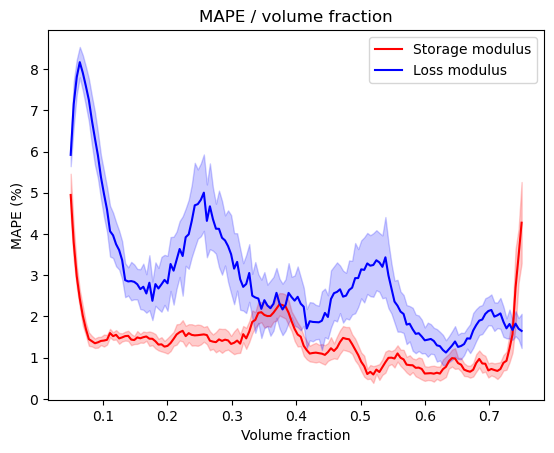

In [29]:
MAPE = WeightedMeanAbsolutePercentageError().to(device)
torch.cuda.empty_cache()
microstructure_dataset =  CustomDataset(microstructure_images[0:14996], G[0:14996],G_prime[0:14996])
microstructure_dataset = DataLoader(microstructure_dataset, batch_size=4, shuffle=False)

MAPE_fraction_storage = []
MAPE_fraction_loss = []

model.eval()
for batch_data, (batch_target1,batch_target2) in microstructure_dataset: 
        batch_data = batch_data.to(device)
        out1, out2 = model(batch_data)
        target1 = batch_target1.to(device)
        target2 = batch_target2.to(device)
        
        MAPE_fraction_storage.append(MAPE(out1, target1).item())
        MAPE_fraction_loss.append(MAPE(out2, target2).item())
        
mean_storage = []
std_storage = []
mean_loss = []
std_loss = []

for i in range(149):
    mean_storage.append(np.mean(100*np.array(MAPE_fraction_storage[i*25:(i+1)*25])))
    mean_loss.append(np.mean(100*np.array(MAPE_fraction_loss[i*25:(i+1)*25])))
    std_storage.append(np.std(100*np.array(MAPE_fraction_storage[i*25:(i+1)*25])))
    std_loss.append(np.std(100*np.array(MAPE_fraction_loss[i*25:(i+1)*25])))
    
mean_storage.append(np.mean(100*np.array(MAPE_fraction_storage[149*25:])))
mean_loss.append(np.mean(100*np.array(MAPE_fraction_loss[149*25:])))
std_storage.append(np.std(100*np.array(MAPE_fraction_storage[149*25:])))
std_loss.append(np.std(100*np.array(MAPE_fraction_loss[149*25:])))
    
X_frac = np.linspace(0.05, 0.75, 150)

ecart_sup_storage = np.array(mean_storage) + np.array(std_storage)
ecart_inf_storage = np.array(mean_storage) - np.array(std_storage)
ecart_sup_loss = np.array(mean_loss) + np.array(std_loss)
ecart_inf_loss = np.array(mean_loss) - np.array(std_loss)

plt.plot(X_frac,mean_storage, label = 'Storage modulus', color = 'red')
plt.fill_between(X_frac, ecart_sup_storage, ecart_inf_storage, alpha=0.2, color='red')
plt.plot(X_frac,mean_loss, label = 'Loss modulus', color = 'blue')
plt.fill_between(X_frac, ecart_sup_loss, ecart_inf_loss, alpha=0.2, color='blue')
plt.title("MAPE / volume fraction")
plt.xlabel('Volume fraction')
plt.ylabel('MAPE (%)')
plt.legend()
plt.show()



# Save/load the model:

To save the model:

In [45]:
save_path = "best_model_1.pt" #Endroit où on veut sauvegarder le modèle
torch.save(model.state_dict(), save_path)

To load the model:

In [ ]:
load_path = "best_model_1.pt" #Endroit où le modèle a été sauvegardé
best_model = CNNLSTM()
best_model.load_state_dict(torch.load(load_path))